In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rasterio
import geowrangler.raster_zonal_stats as rzs
import geopandas as gpd
import pandas as pd

from pathlib import Path

/home/abbymoreno/miniconda3/envs/lacuna-fund2/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# data files
DATA_DIR = Path("../../../data/")
WP_DIR = DATA_DIR / "02-raw" / "worldpop"

# population count
POP_COUNT = WP_DIR / "unconstrained_phl_ppp_2020.tif"
POP_COUNT_UNADJ = WP_DIR / "phl_ppp_2020_UNadj.tif"
# population density
POP_D = WP_DIR / "phl_pd_2020_1km.tif"
POP_D_UNADJ = WP_DIR / "phl_pd_2020_1km_UNadj.tif"

ADMIN_BOUNDS = DATA_DIR / "01-admin-bounds" / "target_admin_bounds.shp"

# admin bounds
ADMIN_BOUNDS_PROJECT_ID = "tm-geodata-warehouse"
ADMIN_BOUNDS_BQ_TABLE = "ph_admin_boundary_dec2017.level2_province"

### Load AOI

In [3]:
aoi = gpd.read_file(ADMIN_BOUNDS)

In [4]:
# open rasterio
with rasterio.open(POP_COUNT) as src:
    data = src.read(1)
    data_crs = src.crs
    data_bounds = src.bounds

print(data.shape, data_crs, data_bounds)

(19781, 11613) EPSG:4326 BoundingBox(left=116.927916214, bottom=4.586250183000001, right=126.605416175, top=21.070416784)


In [5]:
aoi.groupby(["ADM1_EN", "ADM2_EN", "ADM3_EN"])["ADM3_EN"].count()

ADM1_EN                  ADM2_EN               ADM3_EN            
National Capital Region  NCR, Fourth District  City of Muntinlupa       9
                         NCR, Second District  City of Mandaluyong     27
                         NCR, Third District   City of Navotas         14
Region I                 Pangasinan            Dagupan City            31
Region III               Nueva Ecija           Palayan City            19
Region IX                Zamboanga del Sur     Zamboanga City         101
Region V                 Albay                 Legazpi City            70
Region VI                Iloilo                Iloilo City            180
Region VII               Cebu                  Mandaue City            27
Region VIII              Leyte                 Tacloban City          138
Region X                 Misamis Oriental      Cagayan de Oro City     80
Region XI                Davao del Sur         Davao City             183
Name: ADM3_EN, dtype: int64

# Population Count

## Generate raster zonal stats from worldpop `TIF`

In [6]:
%%time
pop_count_stats = rzs.create_raster_zonal_stats(
    aoi,
    POP_COUNT,
    aggregation=dict(
        func=["sum", "count", "mean", "median", "std", "min", "max"],
        column="population",
        output=[
            "wp_total",
            "samples",
            "wp_mean",
            "wp_median",
            "wp_stdev",
            "wp_min",
            "wp_max",
        ],
    ),
    extra_args=dict(nodata=-99999),
)

CPU times: user 5.37 s, sys: 241 ms, total: 5.62 s
Wall time: 5.61 s


In [7]:
pop_count_stats.head()

,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry,wp_min,wp_max,wp_mean,samples,wp_total,wp_stdev,wp_median
0,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Lomboy,PH015518016,"POLYGON ((120.32742 16.05423, 120.32719 16.053...",10.708253,134.088531,19.414621,54,1048.389526,16.566447,16.313622
1,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Tapuac,PH015518031,"POLYGON ((120.33380 16.03974, 120.33389 16.039...",49.934814,171.413712,94.131187,85,8001.150879,23.749223,90.292122
2,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Pantal,PH015518022,"POLYGON ((120.34737 16.06009, 120.34761 16.060...",16.287024,842.690857,164.335341,190,31223.714844,209.994516,61.385437
3,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Barangay I (T. Bugallon),PH015518024,"POLYGON ((120.34054 16.04489, 120.34054 16.044...",58.865456,158.769135,104.896740,21,2202.831543,25.539194,109.470459
4,Region III,PH030000000,Nueva Ecija,PH034900000,Palayan City,PH034919000,Imelda Valley,PH034919017,"POLYGON ((121.12250 15.58028, 121.12687 15.579...",0.835072,26.618620,5.960308,773,4607.318359,4.582612,4.241848


In [8]:
%%time
pop_count_unadj = rzs.create_raster_zonal_stats(
    aoi,
    POP_COUNT_UNADJ,
    aggregation=dict(
        func=["sum", "count", "mean", "median", "std", "min", "max"],
        column="population",
        output=[
            "wp_total",
            "samples",
            "wp_mean",
            "wp_median",
            "wp_stdev",
            "wp_min",
            "wp_max",
        ],
    ),
    extra_args=dict(nodata=-99999),
)

CPU times: user 49.7 s, sys: 2.55 s, total: 52.3 s
Wall time: 52.4 s


In [9]:
pop_count_unadj.head()

,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry,wp_min,wp_max,wp_mean,samples,wp_total,wp_stdev,wp_median
0,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Lomboy,PH015518016,"POLYGON ((120.32742 16.05423, 120.32719 16.053...",10.648674,133.342484,19.306602,54,1042.556519,16.474274,16.222855
1,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Tapuac,PH015518031,"POLYGON ((120.33380 16.03974, 120.33389 16.039...",49.656986,170.460007,93.607462,85,7956.634277,23.617087,89.789757
2,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Pantal,PH015518022,"POLYGON ((120.34737 16.06009, 120.34761 16.060...",16.196405,838.002319,163.421001,190,31049.990234,208.826150,61.043900
3,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Barangay I (T. Bugallon),PH015518024,"POLYGON ((120.34054 16.04489, 120.34054 16.044...",58.537941,157.885773,104.313105,21,2190.575195,25.397099,108.861389
4,Region III,PH030000000,Nueva Ecija,PH034900000,Palayan City,PH034919000,Imelda Valley,PH034919017,"POLYGON ((121.12250 15.58028, 121.12687 15.579...",0.830425,26.470520,5.927146,773,4581.684082,4.557115,4.218247


### EDA

In [10]:
# pd.set_option('display.float_format', lambda x: '%.5f' % x)
pop_count_stats.groupby("ADM3_EN")["wp_total"].sum()

ADM3_EN
Cagayan de Oro City    7.520646e+05
City of Mandaluyong    4.112082e+05
City of Muntinlupa     4.786441e+05
City of Navotas        2.872258e+05
Dagupan City           2.083218e+05
Davao City             1.706762e+06
Iloilo City            4.248372e+05
Legazpi City           1.981620e+05
Mandaue City           3.561649e+05
Palayan City           5.556312e+04
Tacloban City          2.003822e+05
Zamboanga City         8.604997e+05
Name: wp_total, dtype: float64

In [11]:
pop_count_unadj.groupby("ADM3_EN")["wp_total"].sum()

ADM3_EN
Cagayan de Oro City    7.478802e+05
City of Mandaluyong    4.089203e+05
City of Muntinlupa     4.759810e+05
City of Navotas        2.856277e+05
Dagupan City           2.071627e+05
Davao City             1.697266e+06
Iloilo City            4.224735e+05
Legazpi City           1.970594e+05
Mandaue City           3.541833e+05
Palayan City           5.525397e+04
Tacloban City          1.992673e+05
Zamboanga City         8.557120e+05
Name: wp_total, dtype: float64

### Calculate MAPE 

In [12]:
# prep per barangay population from PSA
psa_2020 = pd.read_excel(WP_DIR / "PSA_BarangayLevel_2020.xlsx")
psa_2020.head()

,REGION,CITY,BRGY_NAME,PSA_POPULATION
0,NCR,CITY OF MANDALUYONG\n,Addition Hills,108896
1,NCR,CITY OF MANDALUYONG\n,Bagong Silang,4939
2,NCR,CITY OF MANDALUYONG\n,Barangka Drive,15474
3,NCR,CITY OF MANDALUYONG\n,Barangka Ibaba,9040
4,NCR,CITY OF MANDALUYONG\n,Barangka Ilaya,22334


In [13]:
psa_2020.shape

(875, 4)

In [14]:
psa_2020["CITY"] = psa_2020["CITY"].str.rstrip("\n")

In [15]:
psa_2020.dtypes

REGION            object
CITY              object
BRGY_NAME         object
PSA_POPULATION     int64
dtype: object

In [16]:
psa_2020["CITY"] = psa_2020["CITY"].str.lower()
psa_2020["BRGY_NAME"] = psa_2020["BRGY_NAME"].str.lower()
aoi["ADM3_EN"] = aoi["ADM3_EN"].str.lower()
aoi["ADM4_EN"] = aoi["ADM4_EN"].str.lower()

In [17]:
# try joining directly first
# join with admin bounds
psa_joined = pd.merge(
    psa_2020,
    aoi,
    left_on=["CITY", "BRGY_NAME"],
    right_on=["ADM3_EN", "ADM4_EN"],
    validate="one_to_one",
)

In [18]:
psa_joined.head(2)

,REGION,CITY,BRGY_NAME,PSA_POPULATION,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry
0,NCR,city of mandaluyong,addition hills,108896,National Capital Region,PH130000000,"NCR, Second District",PH137400000,city of mandaluyong,PH137401000,addition hills,PH137401001,"POLYGON ((121.04640 14.58746, 121.04636 14.587..."
1,NCR,city of mandaluyong,bagong silang,4939,National Capital Region,PH130000000,"NCR, Second District",PH137400000,city of mandaluyong,PH137401000,bagong silang,PH137401002,"POLYGON ((121.03209 14.59330, 121.03209 14.593..."


We lose 10 barangays after the inner merge. I am guessing they cannot be matched. I will let this go for now.

In [19]:
print("Num barangays from our Admin bounds: ", aoi.shape[0])
print("Num barangays from PSA: ", psa_2020.shape[0])
print("Num barangays after merge: ", psa_joined.shape[0])

Num barangays from our Admin bounds:  879
Num barangays from PSA:  875
Num barangays after merge:  873


In [20]:
psa_joined.groupby(["ADM1_EN", "ADM2_EN", "ADM3_EN"])["ADM3_EN"].count()

ADM1_EN                  ADM2_EN               ADM3_EN            
National Capital Region  NCR, Fourth District  city of muntinlupa       9
                         NCR, Second District  city of mandaluyong     27
                         NCR, Third District   city of navotas         14
Region I                 Pangasinan            dagupan city            31
Region III               Nueva Ecija           palayan city            19
Region IX                Zamboanga del Sur     zamboanga city          98
Region V                 Albay                 legazpi city            68
Region VI                Iloilo                iloilo city            180
Region VII               Cebu                  mandaue city            27
Region VIII              Leyte                 tacloban city          138
Region X                 Misamis Oriental      cagayan de oro city     80
Region XI                Davao del Sur         davao city             182
Name: ADM3_EN, dtype: int64

In [21]:
# drop some rows
psa_joined = psa_joined.drop(columns=["REGION", "CITY", "BRGY_NAME"])
# join with worldpop
worldpop_psa_joined = pop_count_stats.set_index("ADM4_PCODE").join(
    psa_joined.set_index("ADM4_PCODE"), rsuffix="_psa", how="inner"
)

In [22]:
worldpop_psa_joined.shape

(873, 24)

In [23]:
worldpop_psa_joined.columns

Index(['ADM1_EN', 'ADM1_PCODE', 'ADM2_EN', 'ADM2_PCODE', 'ADM3_EN',
       'ADM3_PCODE', 'ADM4_EN', 'geometry', 'wp_min', 'wp_max', 'wp_mean',
       'samples', 'wp_total', 'wp_stdev', 'wp_median', 'PSA_POPULATION',
       'ADM1_EN_psa', 'ADM1_PCODE_psa', 'ADM2_EN_psa', 'ADM2_PCODE_psa',
       'ADM3_EN_psa', 'ADM3_PCODE_psa', 'ADM4_EN_psa', 'geometry_psa'],
      dtype='object')

In [24]:
keep_cols = [
    "ADM1_EN",
    "ADM1_PCODE",
    "ADM2_EN",
    "ADM2_PCODE",
    "ADM3_EN",
    "ADM3_PCODE",
    "ADM4_EN",
    "geometry",
    "wp_total",
    "wp_min",
    "wp_max",
    "wp_mean",
    "wp_stdev",
    "wp_median",
    "PSA_POPULATION",
]
worldpop_psa_joined = worldpop_psa_joined[keep_cols]
worldpop_psa_joined.head(2)

,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,geometry,wp_total,wp_min,wp_max,wp_mean,wp_stdev,wp_median,PSA_POPULATION
ADM4_PCODE,,,,,,,,,,,,,,,
PH015518016,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Lomboy,"POLYGON ((120.32742 16.05423, 120.32719 16.053...",1048.389526,10.708253,134.088531,19.414621,16.566447,16.313622,1300
PH015518031,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Tapuac,"POLYGON ((120.33380 16.03974, 120.33389 16.039...",8001.150879,49.934814,171.413712,94.131187,23.749223,90.292122,5004


In [25]:
worldpop_psa_joined = worldpop_psa_joined.dropna(subset=["wp_total", "PSA_POPULATION"])
# worldpop_psa_joined['population_count'] = worldpop_psa_joined['population_count'].round()

In [26]:
worldpop_psa_joined["ADM3_EN"].unique()

array(['Dagupan City', 'Palayan City', 'Legazpi City', 'Iloilo City',
       'Mandaue City', 'Tacloban City', 'Zamboanga City',
       'Cagayan de Oro City', 'Davao City', 'City of Mandaluyong',
       'City of Navotas', 'City of Muntinlupa'], dtype=object)

In [27]:
worldpop_psa_joined["difference"] = (
    worldpop_psa_joined["wp_total"] - worldpop_psa_joined["PSA_POPULATION"]
)

In [28]:
muntinlupa = worldpop_psa_joined[worldpop_psa_joined["ADM3_EN"] == "City of Muntinlupa"]
mandaluyong = worldpop_psa_joined[
    worldpop_psa_joined["ADM3_EN"] == "City of Mandaluyong"
]
navotas = worldpop_psa_joined[worldpop_psa_joined["ADM3_EN"] == "City of Navotas"]
dagupan = worldpop_psa_joined[worldpop_psa_joined["ADM3_EN"] == "Dagupan City"]
palayan = worldpop_psa_joined[worldpop_psa_joined["ADM3_EN"] == "Palayan City"]
zamboanga = worldpop_psa_joined[worldpop_psa_joined["ADM3_EN"] == "Zamboanga City"]
legazpi = worldpop_psa_joined[worldpop_psa_joined["ADM3_EN"] == "Legazpi City"]
iloilo = worldpop_psa_joined[worldpop_psa_joined["ADM3_EN"] == "Iloilo City"]
mandaue = worldpop_psa_joined[worldpop_psa_joined["ADM3_EN"] == "Mandaue City"]
tacloban = worldpop_psa_joined[worldpop_psa_joined["ADM3_EN"] == "Tacloban City"]
cdo = worldpop_psa_joined[worldpop_psa_joined["ADM3_EN"] == "Cagayan de Oro City"]
davao = worldpop_psa_joined[worldpop_psa_joined["ADM3_EN"] == "Davao City"]

In [29]:
tacloban["wp_total"].isna().value_counts()

False    137
Name: wp_total, dtype: int64

In [94]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


def get_error_metrics(df, city_name):
    y_true = df["PSA_POPULATION"].tolist()
    y_pred = df["wp_total"].tolist()

    mape = mean_absolute_percentage_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    return mape, mae, rmse


def get_statistics(df):
    psa_sum = df["PSA_POPULATION"].sum()
    psa_mean = df["PSA_POPULATION"].mean()
    psa_median = df["PSA_POPULATION"].median()
    psa_std = df["PSA_POPULATION"].std()

    wp_sum = df["wp_total"].sum().round(3)
    wp_mean = df["wp_total"].mean()
    wp_median = df["wp_total"].median()
    wp_std = df["wp_total"].std()

    diff_psa_wp = wp_sum - psa_sum

    return (
        psa_sum,
        psa_mean,
        psa_median,
        psa_std,
        wp_sum,
        wp_mean,
        wp_median,
        wp_std,
        diff_psa_wp,
    )

In [95]:
city_dfs = [
    dagupan,
    palayan,
    legazpi,
    iloilo,
    mandaue,
    tacloban,
    zamboanga,
    cdo,
    davao,
    mandaluyong,
    navotas,
    muntinlupa,
]
city_names = worldpop_psa_joined["ADM3_EN"].unique().tolist()

mape_list = []
mae_list = []
rmse_list = []
stats_lists = {
    "psa_sum": [],
    "wp_sum": [],
    "psa_mean": [],
    "wp_mean": [],
    "psa_median": [],
    "wp_median": [],
    "psa_std": [],
    "wp_std": [],
    "diff_psa_wp": [],
}

for df, name in zip(city_dfs, city_names):
    mape, mae, rmse = get_error_metrics(df, name)
    mape_list.append(mape)
    mae_list.append(mae)
    rmse_list.append(rmse)

    (
        psa_sum,
        psa_mean,
        psa_median,
        psa_std,
        wp_sum,
        wp_mean,
        wp_median,
        wp_std,
        diff_psa_wp,
    ) = get_statistics(df)
    stats_lists["psa_sum"].append(psa_sum)
    stats_lists["psa_mean"].append(psa_mean)
    stats_lists["psa_median"].append(psa_median)
    stats_lists["psa_std"].append(psa_std)
    stats_lists["wp_sum"].append(wp_sum)
    stats_lists["wp_mean"].append(wp_mean)
    stats_lists["wp_median"].append(wp_median)
    stats_lists["wp_std"].append(wp_std)
    stats_lists["diff_psa_wp"].append(diff_psa_wp)

In [96]:
mape_df = pd.DataFrame(
    {"city": city_names, "MAPE": mape_list, "MAE": mae_list, "RMSE": rmse_list}
)
stats_df = pd.DataFrame(stats_lists)

summary_df = pd.concat([mape_df, stats_df], axis=1)

In [97]:
summary_df.sort_values(by="MAPE", ascending=False)

,city,MAPE,MAE,RMSE,psa_sum,wp_sum,psa_mean,wp_mean,psa_median,wp_median,psa_std,wp_std,diff_psa_wp
5,Tacloban City,1.131664,1331.172382,2590.172714,251773,200382.196,1837.759124,1462.643765,691.0,614.279907,2442.219499,2629.172119,-51390.804
10,City of Navotas,1.070613,5347.190142,10661.490120,247543,287225.755,17681.642857,20516.125357,11755.5,11750.602539,19163.619602,20220.387015,39682.755
7,Cagayan de Oro City,0.945305,2689.315466,5169.926032,728402,752064.576,9105.025000,9400.807197,1671.0,2586.737549,14257.779838,16115.445305,23662.576
1,Palayan City,0.865184,1708.859487,2110.875414,45383,55563.117,2388.578947,2924.374586,2131.0,2495.634766,1515.465910,2185.424365,10180.117
8,Davao City,0.826713,3900.631677,7445.312331,1776949,1690857.475,9763.456044,9290.425686,4942.0,4341.629150,13079.373556,15081.445228,-86091.525
3,Iloilo City,0.633823,971.791997,1492.934550,457626,424837.209,2542.366667,2360.206719,1809.5,1818.104126,2559.883368,1978.110169,-32788.791
9,City of Mandaluyong,0.503849,6594.430103,10571.613933,425758,411208.226,15768.814815,15229.934299,8483.0,11407.729492,21131.004336,15075.351435,-14549.774
0,Dagupan City,0.413593,1914.904937,3143.799024,174302,208321.780,5622.645161,6720.057418,4079.0,4014.707031,5491.705992,6988.616862,34019.780
2,Legazpi City,0.410233,1253.644346,2316.069479,205933,195228.389,3028.426471,2871.005716,2211.5,1694.452393,2585.676604,3902.373700,-10704.611
4,Mandaue City,0.394946,4557.821958,5648.387312,364116,356164.897,13485.777778,13191.292480,13832.0,12413.217773,6660.141615,7896.955072,-7951.103


# Visualizations

For sanity checking

### viz utils

In [74]:
def plot_choropleth(city_df, fig_title):
    fig, axs = plt.subplots(ncols=3, figsize=(10, 4))
    psa_min = city_df["PSA_POPULATION"].min()
    psa_max = city_df["PSA_POPULATION"].max()
    # plot map
    city_df.plot(
        column="PSA_POPULATION",
        legend=True,
        legend_kwds={"shrink": 0.3},
        ax=axs[0],
        cmap="YlOrBr",
        vmin=psa_min,
        vmax=psa_max,
    )
    axs[0].set_title("PSA")
    # plot histogram
    city_df.plot(
        column="wp_total",
        legend=True,
        legend_kwds={"shrink": 0.3},
        ax=axs[1],
        cmap="YlOrBr",
        vmin=psa_min,
        vmax=psa_max,
    )
    axs[1].set_title("WorldPop")
    city_df.plot(
        column="difference",
        legend=True,
        legend_kwds={"shrink": 0.3},
        ax=axs[2],
        cmap="coolwarm",
    )
    axs[2].set_title("Difference")

    # adjust layout
    fig.suptitle(fig_title)
    fig.tight_layout()


def plot_histograms(city_df, fig_title):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    # plot map
    sns.histplot(data=city_df, x="PSA_POPULATION", bins=20, ax=axs[0])
    axs[0].set_title("PSA")
    # plot histogram
    sns.histplot(data=city_df, x="wp_total", bins=20, ax=axs[1])
    axs[0].set_title("WorldPop")

    # adjust layout
    fig.suptitle(fig_title)
    fig.tight_layout()

## Cagayan de Oro City

[Text(0.5, 1.0, 'Cagayan de Oro City')]

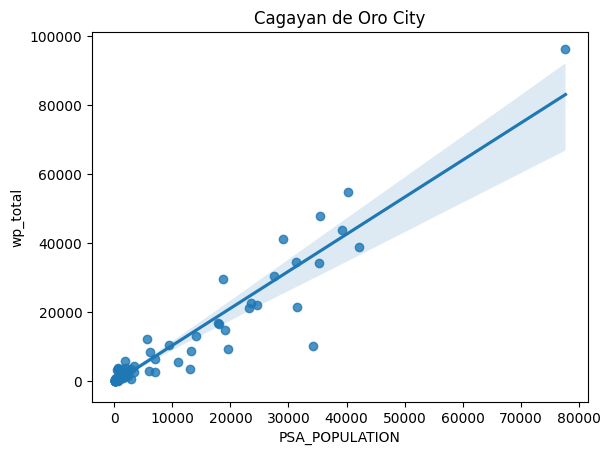

In [89]:
sns.regplot(data=cdo, x="PSA_POPULATION", y="wp_total").set(title="Cagayan de Oro City")

/home/abbymoreno/miniconda3/envs/lacuna-fund2/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/home/abbymoreno/miniconda3/envs/lacuna-fund2/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/home/abbymoreno/miniconda3/envs/lacuna-fund2/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


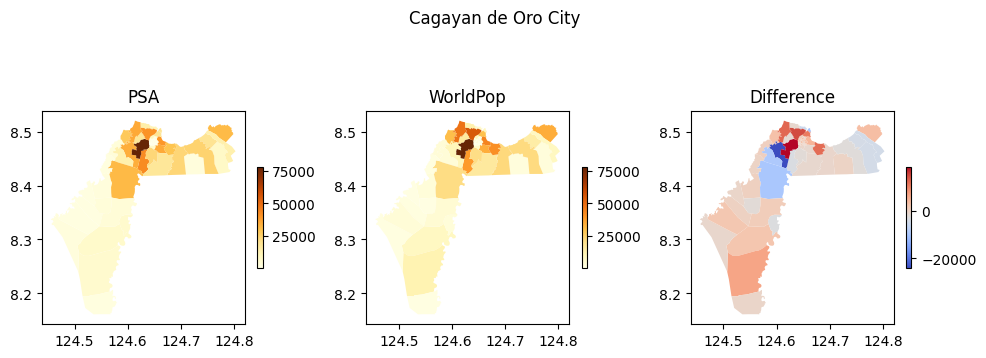

In [90]:
plot_choropleth(cdo, "Cagayan de Oro City")

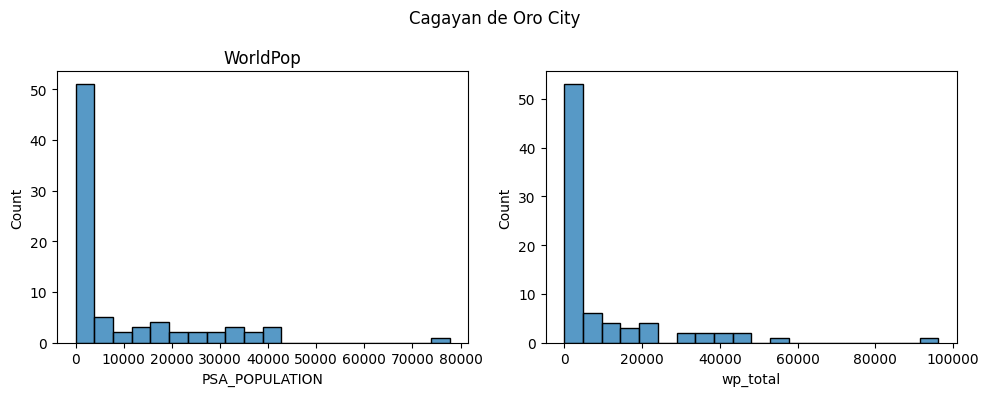

In [91]:
plot_histograms(cdo, "Cagayan de Oro City")

## Mandaluyong City

In [ ]:
plot_choropleth(mandaluyong, "Mandaluyong City")

In [ ]:
plot_histograms(mandaluyong, "Mandaluyong City")

## Muntinlupa City 

In [ ]:
sns.regplot(data=muntinlupa, x="PSA_POPULATION", y="wp_total").set(
    title="Muntinlupa City"
)

In [ ]:
plot_choropleth(muntinlupa, "Muntinlupa City")

In [ ]:
plot_histograms(muntinlupa, "Muntinlupa City")

## Navotas City

In [ ]:
sns.regplot(data=navotas, x="PSA_POPULATION", y="wp_total").set(title="City of Navotas")

In [ ]:
plot_choropleth(navotas, "Navotas City")

In [ ]:
plot_histograms(navotas, "Navotas City")

## Dagupan City

In [ ]:
plot_choropleth(dagupan, "Dagupan City")

In [ ]:
plot_histograms(dagupan, "Dagupan City")

## Davao City

In [ ]:
sns.regplot(data=davao, x="PSA_POPULATION", y="wp_total").set(title="Davao City")

In [ ]:
plot_choropleth(davao, "Davao City")

In [ ]:
plot_histograms(davao, "Davao City")

## Iloilo City

In [ ]:
plot_choropleth(iloilo, "Iloilo City")

In [ ]:
plot_histograms(iloilo, "Iloilo City")

## Legazpi City

In [ ]:
plot_choropleth(legazpi, "Legazpi City")

In [ ]:
plot_histograms(legazpi, "Legazpi City")

## Mandaue City

In [ ]:
plot_choropleth(mandaue, "Mandaue City")

In [ ]:
plot_histograms(mandaue, "Mandaue City")

## Palayan City

In [ ]:
plot_choropleth(palayan, "Palayan City")

In [ ]:
plot_histograms(palayan, "Palayan City")

## Tacloban City

In [ ]:
sns.regplot(data=tacloban, x="PSA_POPULATION", y="wp_total").set(title="Tacloban City")

In [ ]:
plot_choropleth(tacloban, "Tacloban City")

In [ ]:
plot_histograms(tacloban, "Tacloban City")

## Zamboanga City

In [ ]:
sns.regplot(data=zamboanga, x="PSA_POPULATION", y="wp_total").set(
    title="Zamboanga City"
)

In [ ]:
plot_choropleth(zamboanga, "Zamboanga City")

In [ ]:
plot_histograms(zamboanga, "Zamboanga City")

# Population Density

In [50]:
# pop_d = rzs.create_raster_zonal_stats(
#     aoi,
#     POP_D,
#     aggregation=dict(
#         func=["sum", "count", "mean", "median", "std", "min", "max"],
#         column="population",
#         output=[
#             "population_count",
#             "samples",
#             "pop_mean",
#             "pop_median",
#             "pop_stdev",
#             "pop_min",
#             "pop_max",
#         ],
#     ),
#     extra_args=dict(nodata=-99999),
# )

In [51]:
# pop_d.head()

In [52]:
# pop_d_unadj = rzs.create_raster_zonal_stats(
#     aoi,
#     POP_D_UNADJ,
#     aggregation=dict(
#         func=["sum", "count", "mean", "median", "std", "min", "max"],
#         column="population",
#         output=[
#             "population_count",
#             "samples",
#             "pop_mean",
#             "pop_median",
#             "pop_stdev",
#             "pop_min",
#             "pop_max",
#         ],
#     ),
#     extra_args=dict(nodata=-99999),
# )

In [53]:
# pop_d_unadj